In [340]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
from datetime import datetime
import glob
import random
import os
from pathlib import Path
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from pycaret.classification import *
import xgboost
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from lightgbm import LGBMClassifier
from sklearn.svm import SVR
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize, RobustScaler, Normalizer

CATEGORIES = {'high': 1, 'midhigh': 2, 'mid': 3, 'midlow': 4, 'low': 5}
COLORS = ['#476A2A', '#7851B8', '#BD3430', '#4A2D4E', '#875525']

def image_loader_new(folder): 
    base = Path('{}'.format(folder)).glob('**/*')
    all_files = [str(x) for x in base if x.is_file()]
    targets = [x.split('\\')[1] for x in all_files]
    steel_grade = [x.split('\\')[2] for x in all_files]
    dataset = pd.DataFrame({'path': all_files, 'target': targets, 'steel_grade': steel_grade})
    return dataset

def image_preprocess_gray(image, clipLimit=2.27, tileGridSize=(8,8)):
    clahe = cv2.createCLAHE(clipLimit, tileGridSize=tileGridSize) # clipLimit=0.5, tileGridSize=(8,32)
    image                   = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    image                   = image[403:630, :].astype(np.uint8).copy()
    image                   = clahe.apply(image)
    gray                    = image[:, 266:1776].astype(np.uint8).copy()

    return gray

def image_preprocess_value_large_Rolling(image, clipLimit=1.05, tileGridSize=(8,8)):
    clahe = cv2.createCLAHE(clipLimit, tileGridSize=tileGridSize) # clipLimit=0.5, tileGridSize=(8,32)
    image                   = cv2.imread(image, cv2.IMREAD_COLOR)
    image                   = image[388:559, :].astype(np.uint8).copy()
# 1단계: 배경제거코드 적용 : 색상검출방식으로 블룸검출사진 및 스케일검출사진 분리
    image_ycrcb                 = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb) # YCrCb색상으로 변경
# 2단계: 히스토그램 평활화 적용 : contrast 상향
# 2-1) 블룸검출사진 히스토그램 평활화
    planes_cla_bloom        = cv2.split(image_ycrcb)
    planes_cla_bloom[0]     = clahe.apply(planes_cla_bloom[0]) # Y:밝기 히스토그램 평활화 : 컬러이미지
    bloom_ycrcb_aeq         = cv2.merge(planes_cla_bloom)
    bloom_bgr_aeq           = cv2.cvtColor(bloom_ycrcb_aeq, cv2.COLOR_YCrCb2BGR) #  컬러이미지 BGR로 변경
    bloom_hsv_aeq           = cv2.cvtColor(bloom_bgr_aeq, cv2.COLOR_BGR2HSV) #  컬러이미지 HSV로 변경하여 완성!
    planes_aeq_bloom        = cv2.split(bloom_hsv_aeq)

    value                   = planes_aeq_bloom[2] # Value채도
    return value

# 다양한 오차 측정 지표를 확인하기 위한 함수 정의

from sklearn.metrics import *

def get_loss(y_test, y_predict, i): 
    # explained_variance_score =  explained_variance_score(y_test, pred)
    MSE = mean_squared_error(y_test, y_predict)
    RMSE = np.sqrt(MSE)
    r2 = r2_score(y_test, y_predict)
    print('model: {}, MSE: {:.4f}, RMSE: {:.4f}, r2: {:.4f}'.format(Model_name[i], MSE, RMSE, r2))
    
# y_predict = xgb_model.predict(x_test)
# # get_clf_eval()를 이용해 사키릿런 래퍼 XGBoost로 만들어진 모델 예측 성능 평가
# get_loss(y_test, y_predict)

# 사이킷런의 정확도, 정밀도, 재현율, 오차행렬을 계산하는 API 호출
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# 호출한 지표들을 한꺼번에 계산하는 함수 정의
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    print('오차행렬')
    print(confusion)
    print('정확도 : {:.4f}\n정밀도 : {:.4f}\n재현율 : {:.4f}'.format(accuracy, precision, recall))

In [349]:
def data_preprocess(folder, clipLimit, tileGridSize):
    images = image_loader_new(folder)
    # print(images.shape)

    paths = images.path.values # path라는 컬럼의 값을 np.array로 만든다. images['path'].values와 같다.

    hists = []
    for idx, image in enumerate(paths):
        image = image_preprocess_gray(image, clipLimit, tileGridSize)
        hist = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten() # histogram이라는 list를 hists에 넣는다. 2차원 리스트
        hists.append(hist)

    targets = [CATEGORIES[target] for target in images.target.values] # high=1, midhigh=2, mid=3, midlow=4, low=5로 대치한다 

    dataset = pd.DataFrame.from_records(hists) # from_records: list를 dataframe으로 만든다. 0 ~ 255는 x변수로 나타남
    dataset = pd.concat([dataset, pd.DataFrame(targets, columns=['target'])], axis=1) # target도 y변수로 취합한다.
    
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, stratify=dataset['target'], random_state=111) # stratify : 1,2,3,4,5등급을 균등하게 나누어주는 인수

    return dataset, train_dataset, test_dataset

def data_preprocess_large_Rolling(folder, clipLimit, tileGridSize):
    images = image_loader_new(folder)
    # print(images.shape)

    paths = images.path.values # path라는 컬럼의 값을 np.array로 만든다. images['path'].values와 같다.

    hists = []
    for idx, image in enumerate(paths):
        image = image_preprocess_value_large_Rolling(image, clipLimit, tileGridSize)
        hist = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten() # histogram이라는 list를 hists에 넣는다. 2차원 리스트
        hists.append(hist)

    targets = [CATEGORIES[target] for target in images.target.values] # high=1, midhigh=2, mid=3, midlow=4, low=5로 대치한다 

    dataset = pd.DataFrame.from_records(hists) # from_records: list를 dataframe으로 만든다. 0 ~ 255는 x변수로 나타남
    dataset = pd.concat([dataset, pd.DataFrame(targets, columns=['target'])], axis=1) # target도 y변수로 취합한다.
    
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, stratify=dataset['target'], random_state=111) # stratify : 1,2,3,4,5등급을 균등하게 나누어주는 인수

    return dataset, train_dataset, test_dataset

def data_split(dataset):
    X = dataset.drop('target', axis=1)
    Y = dataset['target']

    return X, Y

def XG_preprocessing(y_train, y_test):
    # xgb boost 전처리
    y_train_xgb = [v-1 for v in y_train]
    y_val_xgb = [v-1 for v in y_test]

    return y_train_xgb, y_val_xgb

def robustScaler(train_dataset, validation_dataset):
    # 변형 객체 생성
    robust_scaler = RobustScaler()
    X_train_dataset = train_dataset.drop('target', axis=1)
    #컬럼받기
    Col_Lst = list(X_train_dataset.columns) 
    # Col_Lst들에 전부 스케일러 적용한후 새로운 데이터프레임에 받아줌
    # 새 데이터프레임에도 Col_Lst지정해주어야!!
    train_dataset_scaler = train_dataset.copy()
    validation_dataset_scaler = validation_dataset.copy()

    # 훈련데이터의 모수 분포 저장 및 스케일링
    train_dataset_scaler[Col_Lst] = robust_scaler.fit_transform(train_dataset[Col_Lst]) 
    # 테스트 데이터의 모수 분포 저장 및 스케일링
    validation_dataset_scaler[Col_Lst] = robust_scaler.transform(validation_dataset[Col_Lst])

    return train_dataset_scaler, validation_dataset_scaler


def normalScaler(train_dataset, validation_dataset):
    # 변형 객체 생성
    normal_scaler = Normalizer()
    X_train_dataset = train_dataset.drop('target', axis=1)
    #컬럼받기
    Col_Lst = list(X_train_dataset.columns) 
    # Col_Lst들에 전부 스케일러 적용한후 새로운 데이터프레임에 받아줌
    # 새 데이터프레임에도 Col_Lst지정해주어야!!
    train_dataset_scaler = train_dataset.copy()
    validation_dataset_scaler = validation_dataset.copy()

    # 훈련데이터의 모수 분포 저장 및 스케일링
    train_dataset_scaler[Col_Lst] = normal_scaler.fit_transform(train_dataset[Col_Lst]) 
    # 테스트 데이터의 모수 분포 저장 및 스케일링
    validation_dataset_scaler[Col_Lst] = normal_scaler.transform(validation_dataset[Col_Lst])

    return train_dataset_scaler, validation_dataset_scaler

def select_feature(dataset):
    Col_Lst = [92, 69, 71, 79, 90, 67, 98, 174, 'target']
    dataset([Col_Lst])
    return dataset

In [352]:
clipLimit = 1.05 # 3차 개발
tileGridSize = (8,8)
folder = 'Train_data'
dataset, train_dataset, validation_dataset = data_preprocess_large_Rolling(folder, clipLimit, tileGridSize)
x_train, y_train = data_split(train_dataset)
x_val, y_val = data_split(validation_dataset)
y_train_xgb, y_val_xgb = XG_preprocessing(y_train, y_val)
train_dataset_scaler, validation_dataset_scaler = robustScaler(train_dataset, validation_dataset)
dataset_scaler, validation_dataset_scaler = robustScaler(dataset, validation_dataset)
X, Y = data_split(dataset)
N, Y_xgb = XG_preprocessing(Y, Y)

# feature  선택한 dataframe
dataset_select = dataset[[92, 69, 71, 79, 90, 67, 98, 174, 'target']]
X_select, Y_select = data_split(dataset_select)


print(
    'train_dataset: ', pd.DataFrame(train_dataset).shape,
    'validation_dataset: ', pd.DataFrame(validation_dataset).shape,
    'x_train: ', pd.DataFrame(x_train).shape,
    'y_train: ', pd.DataFrame(y_train).shape,
    'x_val: ', pd.DataFrame(x_val).shape,
    'y_val: ', pd.DataFrame(y_val).shape,
    'y_train_xgb: ', pd.DataFrame(y_train_xgb).shape,
    'y_val_xgb: ', pd.DataFrame(y_val_xgb).shape,
    'train_dataset_scaler: ', pd.DataFrame(train_dataset_scaler).shape,
    'validation_dataset_scaler: ', pd.DataFrame(validation_dataset_scaler).shape,
      )

folder = 'Test_data'
dataset_val, train_dataset_val, validation_dataset_val = data_preprocess_large_Rolling(folder, clipLimit, tileGridSize)
x_test, y_test = data_split(dataset_val)
y_test_xgb, y_test_xgb = XG_preprocessing(y_test, y_test)
N, testset_scaler = robustScaler(dataset_val, dataset_val)
x_test_scaled, y_test = data_split(testset_scaler)

print(
    'x_test: ', pd.DataFrame(x_test).shape,
    'y_test: ', pd.DataFrame(y_test).shape,
    'y_test_xgb: ', pd.DataFrame(y_test_xgb).shape,
    'testset_scaler: ', pd.DataFrame(testset_scaler).shape,
    'x_test_scaled: ', pd.DataFrame(x_test_scaled).shape,
      )

train_dataset:  (1800, 257) validation_dataset:  (450, 257) x_train:  (1800, 256) y_train:  (1800, 1) x_val:  (450, 256) y_val:  (450, 1) y_train_xgb:  (1800, 1) y_val_xgb:  (450, 1) train_dataset_scaler:  (1800, 257) validation_dataset_scaler:  (450, 257)
x_test:  (460, 256) y_test:  (460, 1) y_test_xgb:  (460, 1) testset_scaler:  (460, 257) x_test_scaled:  (460, 256)


In [367]:
# # 선형회귀
# mlr_model = LinearRegression()

# mlr_model.fit(x_train, y_train)
# model0 = mlr_model.predict(x_test)
# xgb boost(Exstream Gradient Boosting Machine)
xgb_model = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=6031, reg_alpha=0)
xgb_model.fit(X, Y_xgb) # _get_numeric_data()
model0 = xgb_model.predict(x_test)
# randomforest
rf_model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=6031, verbose=0,
                       warm_start=False)
rf_model.fit(X,Y)
model1 = rf_model.predict(x_test)
# light GMB(Gradient Boosting Machine) 
LGBM_model = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=6031, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
LGBM_model.fit(X,Y)
model2 = LGBM_model.predict(x_test)
# ExtraTreesClassifier
xtree_model = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=18, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0000534, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=9,
                     min_weight_fraction_leaf=0.000005, n_estimators=76, n_jobs=-1,
                     oob_score=False, random_state=3702, verbose=0,
                     warm_start=False)
xtree_model.fit(X,Y)
model3 = xtree_model.predict(x_test)

# ExtraTreesClassifier_feature_selection
xtree_model_select = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=18, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0000534, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=9,
                     min_weight_fraction_leaf=0.000005, n_estimators=76, n_jobs=-1,
                     oob_score=False, random_state=3702, verbose=0,
                     warm_start=False)
xtree_model_select.fit(X,Y)
model4 = xtree_model_select.predict(x_test)

print(len(x_train), len(x_test))

1800 460


In [368]:
Model_call = {'model0' : model0, 'model1' : model1, 'model2':model2, 'model3':model3, 'model4':model4}
Model_name = {0 : 'xgb boost', 1 : 'randomforest', 2:'light GBM', 3:'ExtraTrees', 4:'ExtraTrees_selcted'}
pred_class = np.array([v+1 for v in model1])





# for i in np.arange(5):
    # a = 'model{}'.format(i)
print('xgb boost: ', Model_name[0])
get_clf_eval(y_test_xgb, model0)
print('randomforest: ', Model_name[1])
get_clf_eval(y_test, model1)
print('light GBM: ', Model_name[2])
get_clf_eval(y_test, model2)
print('ExtraTrees: ', Model_name[3])
get_clf_eval(y_test, model3)
print('ExtraTrees_selcted: ', Model_name[4])
get_clf_eval(y_test, model4)

xgb boost:  xgb boost
오차행렬
[[ 80   0   0   0   0]
 [  0  92   8   2   1]
 [  0   3  37   8   2]
 [  0   0   2  51   0]
 [  1   6   1  12 154]]
정확도 : 0.9000
정밀도 : 0.9000
재현율 : 0.9000
randomforest:  randomforest
오차행렬
[[ 80   0   0   0   0]
 [  1  90   8   3   1]
 [  0   1  39   7   3]
 [  0   1   1  51   0]
 [  2   8   1  14 149]]
정확도 : 0.8891
정밀도 : 0.8891
재현율 : 0.8891
light GBM:  light GBM
오차행렬
[[ 80   0   0   0   0]
 [  1  94   6   2   0]
 [  0   2  39   7   2]
 [  0   1   1  51   0]
 [  1   3   1  12 157]]
정확도 : 0.9152
정밀도 : 0.9152
재현율 : 0.9152
ExtraTrees:  ExtraTrees
오차행렬
[[ 80   0   0   0   0]
 [  1  92   7   2   1]
 [  0   2  42   3   3]
 [  0   2   1  50   0]
 [  2   8   0  13 151]]
정확도 : 0.9022
정밀도 : 0.9022
재현율 : 0.9022
ExtraTrees_selcted:  ExtraTrees_selcted
오차행렬
[[ 80   0   0   0   0]
 [  1  92   7   2   1]
 [  0   2  42   3   3]
 [  0   2   1  50   0]
 [  2   8   0  13 151]]
정확도 : 0.9022
정밀도 : 0.9022
재현율 : 0.9022


In [358]:
auto = setup(data=dataset, target="target",
            train_size = 0.8,
            data_split_stratify = True,
            categorical_features = None,
            session_id = 3702,
            log_experiment=True, experiment_name = "Turbo")
get_config('prep_pipe').named_steps["dtypes"].replacement

,Description,Value
0,session_id,3702
1,Target,target
2,Target Type,Multiclass
3,Label Encoded,"1: 0, 2: 1, 3: 2, 4: 3, 5: 4"
4,Original Data,"(2250, 257)"
5,Missing Values,False
6,Numeric Features,256
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

In [359]:
best_4 = compare_models(n_select=4, turbo=False, fold = 10)
print(best_4)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9061,0.9887,0.9061,0.9081,0.9063,0.8826,0.8830,0.2960
lightgbm,Light Gradient Boosting Machine,0.9044,0.9860,0.9044,0.9080,0.9050,0.8806,0.8811,1.6050
xgboost,Extreme Gradient Boosting,0.8956,0.9840,0.8956,0.8983,0.8960,0.8694,0.8699,2.6430
rf,Random Forest Classifier,0.8906,0.9841,0.8906,0.8939,0.8909,0.8632,0.8639,0.4800
gbc,Gradient Boosting Classifier,0.8683,0.9781,0.8683,0.8728,0.8686,0.8354,0.8363,5.8510
knn,K Neighbors Classifier,0.8089,0.9466,0.8089,0.8087,0.8074,0.7611,0.7618,0.0830
dt,Decision Tree Classifier,0.8072,0.8795,0.8072,0.8097,0.8067,0.7590,0.7599,0.0850
mlp,MLP Classifier,0.7961,0.9029,0.7961,0.8161,0.7922,0.7451,0.7517,0.3160
qda,Quadratic Discriminant Analysis,0.7511,0.9212,0.7511,0.7554,0.7479,0.6889,0.6916,0.0190
lr,Logistic Regression,0.7450,0.9287,0.7450,0.7454,0.7432,0.6812,0.6823,0.6560


[ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=3702, verbose=0,
                     warm_start=False), LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=3702, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0), XGBClass

In [7]:
top4 = [rank for rank in best_4] 
tuned_top4 = [tune_model(estimator=i , fold = 10,
                       choose_better = True, optimize = 'Accuracy') for i in top4]
print(tuned_top4)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8778,0.9851,0.8778,0.8796,0.8781,0.8472,0.8475
1,0.8833,0.9862,0.8833,0.8824,0.8817,0.8542,0.8547
2,0.8556,0.9713,0.8556,0.8553,0.8538,0.8194,0.8202
3,0.8778,0.9810,0.8778,0.8826,0.8775,0.8472,0.8486
4,0.8333,0.9684,0.8333,0.8329,0.8330,0.7917,0.7917
5,0.8778,0.9846,0.8778,0.8803,0.8785,0.8472,0.8475
6,0.8667,0.9810,0.8667,0.8697,0.8673,0.8333,0.8338
7,0.9278,0.9934,0.9278,0.9288,0.9282,0.9097,0.9098
8,0.8389,0.9708,0.8389,0.8402,0.8393,0.7986,0.7987
9,0.8167,0.9681,0.8167,0.8221,0.8182,0.7708,0.7714


[ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=6031, verbose=0,
                     warm_start=False), LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=6031, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0), XGBClass

In [8]:
blended = blend_models(estimator_list = tuned_top4,
                       fold = 10,
                       choose_better = True,
                       optimize='Accuracy',
                       )

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9222,0.9949,0.9222,0.9236,0.9226,0.9028,0.9030
1,0.9278,0.9951,0.9278,0.9290,0.9269,0.9097,0.9104
2,0.8889,0.9841,0.8889,0.8909,0.8877,0.8611,0.8622
3,0.9056,0.9887,0.9056,0.9071,0.9054,0.8819,0.8824
4,0.8722,0.9811,0.8722,0.8722,0.8713,0.8403,0.8407
5,0.9056,0.9911,0.9056,0.9085,0.9063,0.8819,0.8823
6,0.8611,0.9836,0.8611,0.8653,0.8623,0.8264,0.8268
7,0.9722,0.9984,0.9722,0.9727,0.9723,0.9653,0.9654
8,0.8722,0.9744,0.8722,0.8749,0.8722,0.8403,0.8410
9,0.8556,0.9810,0.8556,0.8618,0.8576,0.8194,0.8199


In [9]:
#Finalize model_cat
final_model = finalize_model(blended)

In [10]:
#Predict - 최종모델로 예측 진행!
predict_bld = predict_model(estimator=final_model, data=dataset_val)
predict_bld

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,target,Label,Score
0,0.0,0.0,12084.0,86.0,826.0,383.0,205.0,121.0,72.0,51.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.97
1,0.0,0.0,13456.0,482.0,2183.0,1799.0,480.0,578.0,384.0,242.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.98
2,0.0,0.0,20534.0,173.0,706.0,321.0,162.0,103.0,73.0,39.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1.00
3,0.0,0.0,5074.0,711.0,2138.0,2136.0,800.0,987.0,758.0,456.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.99
4,0.0,0.0,19311.0,145.0,400.0,367.0,237.0,106.0,91.0,51.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,0.0,2.0,18196.0,533.0,2649.0,1282.0,964.0,1056.0,1093.0,1028.0,...,63.0,55.0,41.0,48.0,49.0,41.0,392.0,4,4,0.93
456,0.0,14.0,11118.0,1786.0,5455.0,7898.0,5470.0,9682.0,8461.0,10216.0,...,332.0,335.0,352.0,318.0,350.0,317.0,7260.0,4,4,0.97
457,0.0,16.0,14227.0,1534.0,4849.0,5965.0,4243.0,7902.0,6513.0,11423.0,...,82.0,77.0,63.0,55.0,49.0,58.0,246.0,4,4,0.98
458,0.0,0.0,15653.0,162.0,186.0,319.0,133.0,158.0,160.0,135.0,...,1.0,2.0,2.0,0.0,0.0,0.0,0.0,4,4,0.93


In [11]:
et = create_model('et')
print(et)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9333,0.9959,0.9333,0.9342,0.9331,0.9167,0.9170
1,0.9389,0.9954,0.9389,0.9401,0.9382,0.9236,0.9242
2,0.9222,0.9888,0.9222,0.9245,0.9216,0.9028,0.9036
3,0.9000,0.9867,0.9000,0.9012,0.8997,0.8750,0.8754
4,0.8833,0.9835,0.8833,0.8849,0.8827,0.8542,0.8548
5,0.9333,0.9887,0.9333,0.9337,0.9331,0.9167,0.9169
6,0.8889,0.9877,0.8889,0.8926,0.8896,0.8611,0.8617
7,0.9611,0.9977,0.9611,0.9642,0.9614,0.9514,0.9520
8,0.8500,0.9771,0.8500,0.8589,0.8528,0.8125,0.8135
9,0.8833,0.9846,0.8833,0.8879,0.8847,0.8542,0.8546


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=6031, verbose=0,
                     warm_start=False)


In [12]:
tune_et = tune_model(estimator= et, fold = 10,
                       choose_better = True, optimize = 'Accuracy')
print(tune_et)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8778,0.9824,0.8778,0.8815,0.8777,0.8472,0.8482
1,0.8833,0.9824,0.8833,0.8837,0.8823,0.8542,0.8547
2,0.8222,0.9691,0.8222,0.8238,0.8227,0.7778,0.7779
3,0.8944,0.9779,0.8944,0.8966,0.8942,0.8681,0.8686
4,0.8278,0.9748,0.8278,0.8277,0.8269,0.7847,0.7851
5,0.8722,0.9788,0.8722,0.8756,0.8729,0.8403,0.8408
6,0.8500,0.9786,0.8500,0.8512,0.8483,0.8125,0.8137
7,0.9000,0.9866,0.9000,0.9045,0.9004,0.8750,0.8759
8,0.8056,0.9579,0.8056,0.8066,0.8054,0.7569,0.7573
9,0.8444,0.9717,0.8444,0.8477,0.8449,0.8056,0.8062


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=6031, verbose=0,
                     warm_start=False)


In [13]:
predict_et = predict_model(estimator=tune_et, data=validation_dataset)
predict_et

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,target,Label,Score
1635,0.0,0.0,14385.0,35.0,5285.0,463.0,182.0,200.0,79.0,104.0,...,4.0,4.0,7.0,4.0,3.0,4.0,13.0,2,2,1.00
1977,0.0,2.0,6.0,4.0,16.0,8.0,25.0,18.0,17.0,43.0,...,458.0,393.0,365.0,386.0,359.0,291.0,3552.0,4,4,1.00
91,0.0,0.0,63728.0,923.0,6143.0,4964.0,944.0,1740.0,1184.0,493.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1,1,1.00
1985,0.0,20.0,20030.0,879.0,2354.0,2476.0,2553.0,2778.0,2650.0,3111.0,...,0.0,2.0,0.0,0.0,0.0,1.0,0.0,4,4,1.00
1162,0.0,0.0,14682.0,256.0,348.0,181.0,113.0,87.0,72.0,75.0,...,6.0,11.0,12.0,3.0,4.0,7.0,30.0,3,3,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1801,0.0,0.0,16627.0,3156.0,1875.0,1892.0,669.0,667.0,428.0,306.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4,4,1.00
405,0.0,0.0,12281.0,1181.0,5298.0,4780.0,966.0,1677.0,1173.0,514.0,...,21.0,25.0,11.0,9.0,6.0,9.0,13.0,1,1,1.00
2080,0.0,2.0,17491.0,35.0,1983.0,371.0,282.0,280.0,190.0,435.0,...,14.0,6.0,9.0,7.0,2.0,0.0,2.0,4,4,0.35
1901,0.0,0.0,38174.0,4664.0,6855.0,3767.0,3652.0,1675.0,1809.0,1099.0,...,322.0,300.0,287.0,278.0,254.0,223.0,1788.0,4,4,1.00


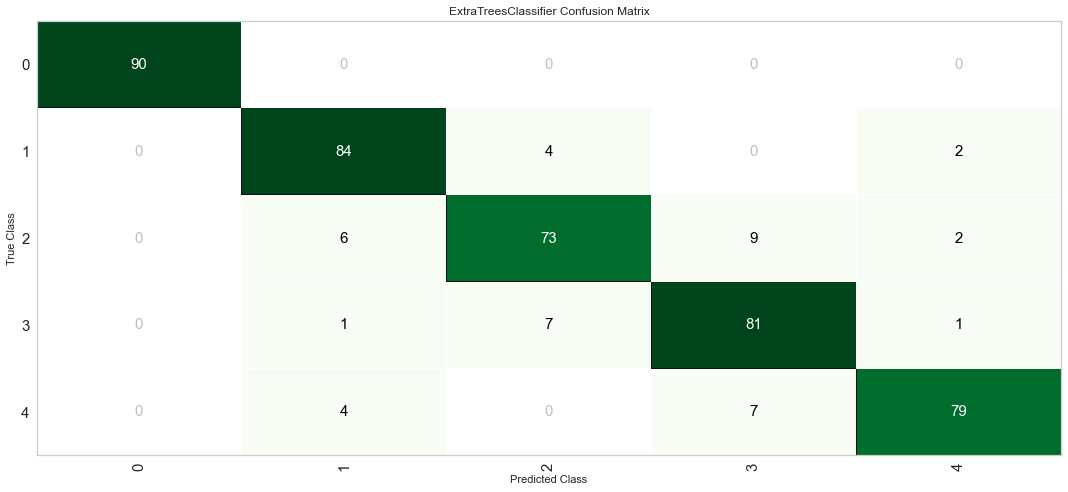

In [14]:
plt.figure(figsize=(15, 7))
plot_model(estimator = tune_et, plot='confusion_matrix')
plt.rc('font', size=50)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=30)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=20)  # 범례 폰트 크기
plt.rc('figure', titlesize=100) # figure title 폰트 크기
plt.show()
#plot_model(estimator = tune_gbr, plot='residuals')
#plot_model(estimator = tune_omp, plot='feature')
#plot_model(estimator = mlp, plot='error')
# plot_model(estimator = tune_mlp, plot='learning')
# plot_model(estimator = tune_mlp, plot='manifold')
# plot_model(estimator = tune_mlp, plot='vc')
# plot_model(estimator = tune_mlp, plot='parameter')

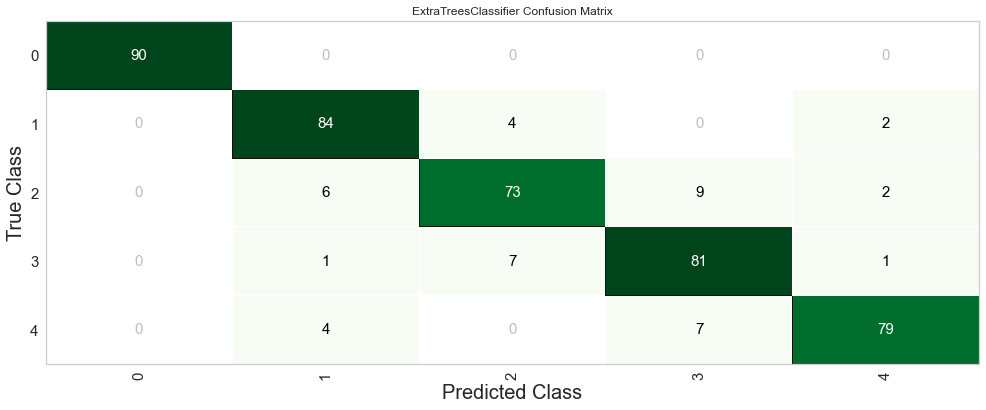

In [15]:
plt.figure(figsize=(15, 7))
plot_model(estimator = blended, plot='confusion_matrix')
plt.rc('font', size=50)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=30)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=20)  # 범례 폰트 크기
plt.rc('figure', titlesize=100) # figure title 폰트 크기
plt.show()
#plot_model(estimator = tune_gbr, plot='residuals')
#plot_model(estimator = tune_omp, plot='feature')
#plot_model(estimator = mlp, plot='error')
# plot_model(estimator = tune_mlp, plot='learning')
# plot_model(estimator = tune_mlp, plot='manifold')
# plot_model(estimator = tune_mlp, plot='vc')
# plot_model(estimator = tune_mlp, plot='parameter')

In [32]:
evaluate_model(tune_et)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [337]:
print(xtree_model.feature_importances_)
feature_list = pd.concat([pd.Series(X.columns), pd.Series(xtree_model.feature_importances_)], axis=1)
feature_list.columns = ['features_name', 'importance']
feature_list.sort_values("importance", ascending =False)[:8]

[0.         0.00106779 0.00164199 0.00178449 0.00128586 0.00125355
 0.00155668 0.00214107 0.00151209 0.00138916 0.00233154 0.00322762
 0.00358353 0.0043074  0.001935   0.00170836 0.00267644 0.0019499
 0.00210699 0.00178185 0.00260998 0.00289984 0.00235955 0.0028043
 0.00357497 0.00193502 0.00203368 0.00244092 0.00281959 0.00265531
 0.00233435 0.00142094 0.00148097 0.00203048 0.00173025 0.00277932
 0.00284536 0.00365067 0.0022111  0.00409669 0.00214551 0.00313427
 0.00238782 0.00313768 0.0017503  0.00180832 0.00229804 0.00231882
 0.00362366 0.00502231 0.00270158 0.0041314  0.00581627 0.00683977
 0.00432698 0.00742754 0.00302609 0.00907659 0.00399044 0.00301818
 0.00516363 0.00823164 0.0028105  0.00421926 0.00506756 0.00777922
 0.00399055 0.01039109 0.00691035 0.00797957 0.00612829 0.01121141
 0.00324568 0.00267238 0.00268473 0.00494754 0.00789347 0.00269002
 0.00929065 0.01089411 0.00586249 0.00673804 0.00751827 0.00507257
 0.0055337  0.00777764 0.00420243 0.00757106 0.00684511 0.008155

,features_name,importance
92,92,0.013033
96,96,0.012300
71,71,0.011211
79,79,0.010894
90,90,0.010864
67,67,0.010391
98,98,0.009485
174,174,0.009439


In [369]:
joblib.dump(xtree_model, f'./models/xtree_model_dataset_tune_largeRolling_{datetime.today().strftime("%Y%m%d")}.joblib')

['./models/xtree_model_dataset_tune_largeRolling_20220529.joblib']

In [371]:
model_et = joblib.load('models\\xtree_model_dataset_tune_largeRolling_20220529.joblib')
preds = model_et.predict(x_test)
proba = model_et.predict_proba(x_test)
print(proba)

get_clf_eval(y_test, preds)

[[9.05771469e-01 5.71677113e-02 6.57894737e-03 0.00000000e+00
  3.04818728e-02]
 [9.95117749e-01 3.75394520e-03 0.00000000e+00 0.00000000e+00
  1.12830564e-03]
 [9.58930196e-01 1.98493027e-02 0.00000000e+00 0.00000000e+00
  2.12205015e-02]
 ...
 [4.38596491e-03 1.42543860e-02 5.83959900e-02 8.98041980e-01
  2.49216792e-02]
 [0.00000000e+00 3.86996904e-04 7.44375701e-02 9.19425507e-01
  5.74992562e-03]
 [0.00000000e+00 8.45864662e-03 4.97037563e-02 9.34797427e-01
  7.04016987e-03]]
오차행렬
[[ 80   0   0   0   0]
 [  1  92   7   2   1]
 [  0   2  42   3   3]
 [  0   2   1  50   0]
 [  2   8   0  13 151]]
정확도 : 0.9022
정밀도 : 0.9022
재현율 : 0.9022


In [372]:
roc_auc_score(y_test, proba, multi_class='ovr')

0.9847885735740153

In [373]:
y_test_lb = label_binarize(y_test, classes=[1, 2, 3, 4, 5])

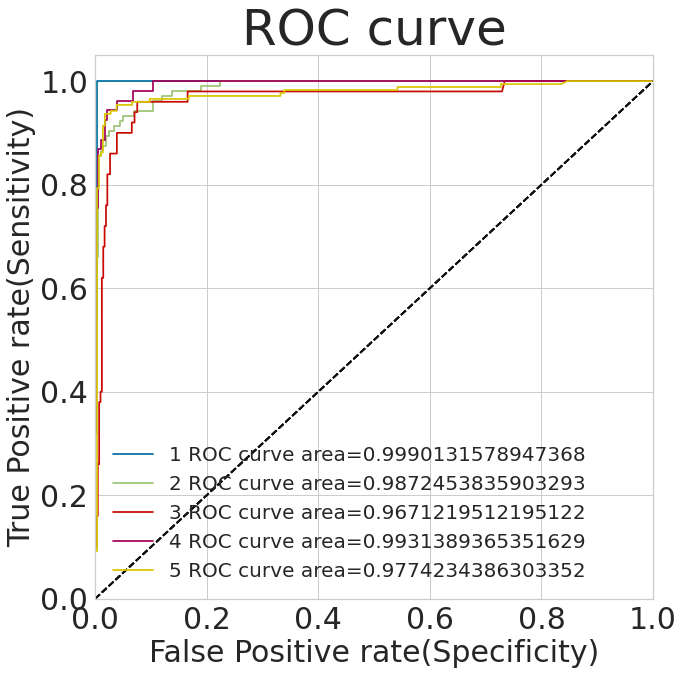

In [377]:
fpr, tpr, roc_auc = {}, {}, {}

for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test_lb[:, i], proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(10, 10))
for idx, i in enumerate(range(5)):
    plt.subplot()
    plt.plot(fpr[i], tpr[i], label=f'{i+1} ROC curve area={roc_auc[i]}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive rate(Specificity)') # 0인 케이스에 대해 0이라고 예측한 것
    plt.ylabel('True Positive rate(Sensitivity)') # 1인 케이스에 대해 1이라고 예측한 것
    plt.title('ROC curve', fontsize=50)
    plt.rc('font', size=100)        # 기본 폰트 크기
    plt.rc('axes', labelsize=30)   # x,y축 label 폰트 크기
    plt.rc('xtick', labelsize=30)  # x축 눈금 폰트 크기 
    plt.rc('ytick', labelsize=30)  # y축 눈금 폰트 크기
    plt.rc('legend', fontsize=20)  # 범례 폰트 크기
    plt.rc('figure', titlesize=50) # figure title 폰트 크기
    plt.legend()
    
plt.show()

Text(0.5, 1.0, 'Confusion Matrix')

<Figure size 1080x1080 with 0 Axes>

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


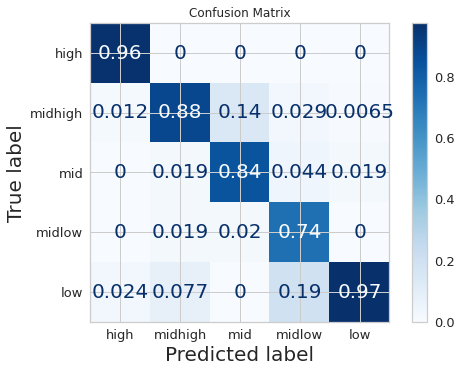

In [333]:
import matplotlib as mpl
# confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

label=['high', 'midhigh', 'mid', 'midlow', 'low'] # 라벨 설정

mpl.rcParams['font.family'] = 'NanumGothic'
plt.figure(figsize=(15, 15))


plot = plot_confusion_matrix(model_et, # 분류 모델
                             x_test, y_test, # 예측 데이터와 예측값의 정답(y_true)
                             display_labels=label, # 표에 표시할 labels
                             cmap=plt.cm.Blues, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize='pred') # 'true', 'pred', 'all' 중에서 지정 가능. default=None
plt.title('title', fontsize=30) # figure title 폰트 크기
plt.rc('font', size=20)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=13)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=13)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=10)  # 범례 폰트 크기
plt.rc('figure', titlesize=10) # figure title 폰트 크기


# plt.rc('font', size=10)        # 기본 폰트 크기




plot.ax_.set_title('Confusion Matrix')

Fitting 10 folds for each of 8 candidates, totalling 80 fits


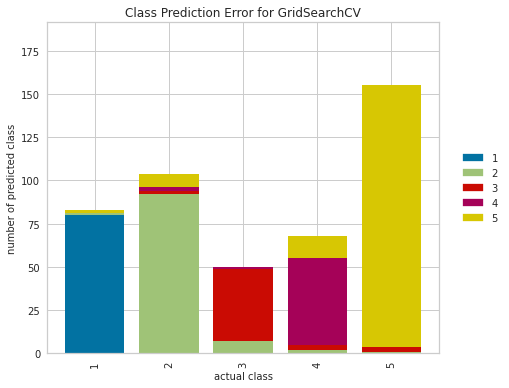

<AxesSubplot:title={'center':'Class Prediction Error for GridSearchCV'}, xlabel='actual class', ylabel='number of predicted class'>

In [365]:
from yellowbrick.classifier import ClassPredictionError
from sklearn.model_selection import GridSearchCV

label = {
        1 : 'high',
        2 : 'midhigh',
        3 : 'mid',
        4 : 'midlow',
        5 : 'low'
        }
plt.title('title', fontsize=10) # figure title 폰트 크기
plt.rc('font', size=10)        # 기본 폰트 크기
plt.rc('axes', labelsize=10)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=10)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=10)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=10)  # 범례 폰트 크기
plt.rc('figure', titlesize=10) # figure title 폰트 크기


# ExtraTreesClassifier
xtree_model = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=18, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0000534, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=8,
                     min_weight_fraction_leaf=0.000005, n_estimators=76, n_jobs=-1,
                     oob_score=False, random_state=3702, verbose=0,
                     warm_start=False)


# parameters = {'max_depth':[7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22], 'min_samples_split':[2,3,4,5,6,7,8,9,10,11,12,13,14,15], 'ccp_alpha' : [v for v in np.arange(0, 10, 1)]}
# parameters = {
#             'min_samples_split':[9], 'ccp_alpha' : [0.0], 'max_depth':[18],
#             'min_impurity_decrease': [0.0000534],
#             }
parameters = {
            'ccp_alpha' : [0.0], 'max_depth':[18], 'min_samples_split':[8,9], 'min_impurity_decrease': [0.0000534], 'min_samples_leaf' : [1], 'min_weight_fraction_leaf' : [0.000005],
            'n_estimators' : [73, 74, 75, 76], 'random_state' :[3702]
            
            }

# param_grid의 하이퍼 파라미터들을 3개의 train, test set fold 로 나누어서 테스트 수행 설정.  
### refit=True 가 default 임. True이면 가장 좋은 파라미터 설정으로 재 학습 시킴.  
grid_xtree = GridSearchCV(xtree_model, param_grid=parameters, cv=10, refit=True, n_jobs=-1, verbose=10)

# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    grid_xtree)

# Fit the training data to the visualizer
visualizer.fit(X,Y)

# Evaluate the model on the test data
visualizer.score(x_test, y_test)

# GridSearchCV 결과 추출하여 DataFrame으로 변환
scores_df = pd.DataFrame(grid_xtree.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score', \
           'split0_test_score', 
           'split1_test_score', 
           'split2_test_score', 
           'split3_test_score', 
           'split4_test_score',
           'split5_test_score',
           'split6_test_score',
           'split7_test_score',
           'split8_test_score',
           'split9_test_score'
            ]]

# Draw visualization
visualizer.show()



In [366]:
print('GridSearchCV 최적 파라미터:', grid_xtree.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_xtree.best_score_))

# GridSearchCV의 refit으로 이미 학습이 된 estimator 반환
estimator = grid_xtree.best_estimator_

# GridSearchCV의 best_estimator_는 이미 최적 하이퍼 파라미터로 학습이 됨
pred = estimator.predict(x_test)
print('테스트 데이터 세트 정확도: {0:.4f}'.format(accuracy_score(y_test,pred)))
scores_df.to_csv('하이퍼파라미터 튜닝.csv')

GridSearchCV 최적 파라미터: {'ccp_alpha': 0.0, 'max_depth': 18, 'min_impurity_decrease': 5.34e-05, 'min_samples_leaf': 1, 'min_samples_split': 9, 'min_weight_fraction_leaf': 5e-06, 'n_estimators': 76, 'random_state': 3702}
GridSearchCV 최고 정확도: 0.7964
테스트 데이터 세트 정확도: 0.9022


In [378]:
preds = xtree_model.predict(x_test)
proba = xtree_model.predict_proba(x_test)
print(proba)

get_clf_eval(y_test, preds)

[[9.05771469e-01 5.71677113e-02 6.57894737e-03 0.00000000e+00
  3.04818728e-02]
 [9.95117749e-01 3.75394520e-03 0.00000000e+00 0.00000000e+00
  1.12830564e-03]
 [9.58930196e-01 1.98493027e-02 0.00000000e+00 0.00000000e+00
  2.12205015e-02]
 ...
 [4.38596491e-03 1.42543860e-02 5.83959900e-02 8.98041980e-01
  2.49216792e-02]
 [0.00000000e+00 3.86996904e-04 7.44375701e-02 9.19425507e-01
  5.74992562e-03]
 [0.00000000e+00 8.45864662e-03 4.97037563e-02 9.34797427e-01
  7.04016987e-03]]
오차행렬
[[ 80   0   0   0   0]
 [  1  92   7   2   1]
 [  0   2  42   3   3]
 [  0   2   1  50   0]
 [  2   8   0  13 151]]
정확도 : 0.9022
정밀도 : 0.9022
재현율 : 0.9022
